#Setup

In [0]:
# Import & Settings
import pandas as pd
import numpy as np
import os
from google.colab import drive
from pathlib import Path, PurePath
import random
from collections import defaultdict

!pip install pyDataverse -q
#documentation here: https://pydataverse.readthedocs.io/en/latest/index.html#quickstart
from pyDataverse.api import Api
from pyDataverse.models import Dataverse

In [0]:
import io
import gzip
import json

In [0]:
def setup_local_data():
  drive.mount('/content/drive')
  drive_path=PurePath('/content/drive/My Drive')
  local_dir = drive_path/'COVID-19'/'dataverse'
  #Make /COVID-19 and /dataverse directories if needed...
  if not Path(local_dir).is_dir():
    os.makedirs(local_dir)
  return local_dir

In [0]:
local_dir = setup_local_data()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Connecting Dataverse to Colab


The below code for fetching the dataset is all thanks to Alex Lofgran.



In [0]:
# Establish connection to Dataverse
base_url = 'http://datasets.coronawhy.org'
api = Api(base_url)
print('Dataverse connection status: ', api.status)

Dataverse connection status:  OK


In [0]:
# Get dataverse info
dv = 'task-ties' #alias for task-ties
response = api.get_dataverse(dv)
response.json()

{'data': {'affiliation': 'CoronaWhy',
  'alias': 'task-ties',
  'creationDate': '2020-04-15T22:13:08Z',
  'dataverseContacts': [{'contactEmail': 'dataverse-k8s-contact@mailinator.com',
    'displayOrder': 0}],
  'dataverseType': 'RESEARCH_GROUP',
  'description': 'What is known about transmission, incubation, and environmental stability? More at <a href="https://github.com/CoronaWhy/task-ties">Task Tes github</a>',
  'id': 4,
  'name': 'CoronaWhy Task Ties',
  'ownerId': 1,
  'permissionRoot': True},
 'status': 'OK'}

In [0]:
# Get dataset information by persistent id
dset = 'doi:10.5072/FK2/KKBTXL'
response = api.get_dataset(dset, is_pid = True) # in Dataverse 
print('Response results: ')
display(response.json())
print()

# Get dataset ID
dataset_id = response.json()['data']['id']
print('Dataset ID: ', dataset_id, '\n')

# Get datafile ID
datafile_id = response.json()['data']['latestVersion']['files'][0]['dataFile']['id']
print('Datafile ID: ', datafile_id, '\n')

Response results: 


{'data': {'authority': '10.5072',
  'id': 98,
  'identifier': 'FK2/KKBTXL',
  'latestVersion': {'createTime': '2020-06-03T02:57:20Z',
   'datasetId': 98,
   'datasetPersistentId': 'doi:10.5072/FK2/KKBTXL',
   'fileAccessRequest': False,
   'files': [{'dataFile': {'checksum': {'type': 'MD5',
       'value': '6802ac5c8fb9620452f2a6fd23f16db2'},
      'contentType': 'application/json',
      'creationDate': '2020-06-03',
      'filename': 'time_period_and_age_train.json',
      'filesize': 120141,
      'id': 72320,
      'md5': '6802ac5c8fb9620452f2a6fd23f16db2',
      'persistentId': '',
      'pidURL': '',
      'rootDataFileId': -1,
      'storageIdentifier': '172784e6119-c9f8a9c754d9'},
     'datasetVersionId': 2163,
     'label': 'time_period_and_age_train.json',
     'restricted': False,
     'version': 1}],
   'id': 2163,
   'lastUpdateTime': '2020-06-03T03:51:51Z',
   'license': 'CC0',
   'metadataBlocks': {'citation': {'displayName': 'Citation Metadata',
     'fields': [{'multip


Dataset ID:  98 

Datafile ID:  72320 



In [0]:
# Download datafile to cwd
response = api.get_datafile(datafile_id)
print('File size: ', len(response.content))

# Write the response content to the specified filename
with gzip.open(local_dir/'time_period_age_ner_train.json.gz', 'wb') as f_out:
  f_out.write(response.content)

print('Files in current directory: ', '\n', os.listdir())


File size:  120141
Files in current directory:  
 ['.config', 'drive', 'sample_data']


#Train a custon NER for time periods
#### Source: [How to Train NER with Custom training data using spaCy](https://medium.com/@manivannan_data/how-to-train-ner-with-custom-training-data-using-spacy-188e0e508c6)

In [0]:
# Convert data into spaCy format
def convert_to_spacy_format(dlist):
  SPACY_DATA = []
  for data in dlist:
    if data['content'] !='':
      ents = [tuple(entity) for entity in data['entities']]
      ents = [e for i, e, in enumerate(ents) if e not in ents[i+1:]]
      SPACY_DATA.append((data['content'],{'entities':ents}))
  return SPACY_DATA

In [0]:
# Re-tuning
import spacy
import random
from spacy.util import minibatch, compounding

def train_spacy(data,iterations):
    TRAIN_DATA = data
    nlp = spacy.blank('en')  # create blank Language class
    # create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if 'ner' not in nlp.pipe_names:
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner, last=True)
       

    # add labels
    for _, annotations in TRAIN_DATA:
         for ent in annotations.get('entities'):
            ner.add_label(ent[2])

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
    with nlp.disable_pipes(*other_pipes):  # only train NER
        optimizer = nlp.begin_training()
        loss = []
        for itn in range(iterations):
            print("Starting iteration " + str(itn))
            random.shuffle(TRAIN_DATA)
            losses = {}
            # batch up the examples using spaCy's minibatch
            batches = minibatch(TRAIN_DATA, size=compounding(4.0, 32.0, 1.001))
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(
                    texts,  # batch of texts
                    annotations,  # batch of annotations
                    drop=0.2,  # dropout - make it harder to memorise data
                    losses=losses,
                    sgd = optimizer
                )
            print(losses)
            loss.append(losses['ner'])
        df = pd.DataFrame()
        df['loss'] = loss
    return (nlp, df)

In [0]:
# Read downloaded json gzip file
#with gzip.open(local_dir/'time_period_age_ner_train.json.gz', 'rb') as f:
#    annotated = json.loads(f.read())
#    print('Number of annotated sentences:', len(annotated))

Number of annotated sentences: 462


## Read re-annotated json file

In [0]:
with open(local_dir/'time_period_train_reannotated_spacy.json','r') as f:
  annotated = json.loads(f.read())
  print('Number of annotated sentences:', len(annotated))

Number of annotated sentences: 461


In [0]:
#random.Random(2020).shuffle(annotated)
#train = annotated[:round(len(annotated)*0.8)]
#test = annotated[round(len(annotated)*0.8):]

# New split for re-annotated sentences
random.Random(2021).shuffle(annotated)
train = annotated[:round(len(annotated)*0.8)]
test = annotated[round(len(annotated)*0.8):]

## Convert json to spacy format

In [0]:
TRAIN_DATA = convert_to_spacy_format(train)
TEST_DATA = convert_to_spacy_format(test)

In [0]:
TEST_DATA[:5]

[('For adults, the incubation periods for the majority (66.5%) of the cases were 1-9 days: most of them (57.6% and 52.0% for males and females, respectively) had 1-5 days incubation.',
  {'entities': [(16, 72, 'TPcontext'), (78, 86, 'TPdata')]}),
 ('Shandong Province showed an longer period (more than two weeks) characterized by sustained local transmission and a larger peak value of Rt: 2.17 (95%CI: 1.69-2.76) considering an average serial interval of 5.9 days (Fig. 3C ).',
  {'entities': [(180, 203, 'TPcontext'), (207, 215, 'TPdata')]}),
 ('Comparing those under and over-60 years of age, we find estimates that are consistent with those observed in cases from mainland China (Tables 1 and 2) .',
  {'entities': [(31, 39, 'TPdata'), (43, 46, 'TPcontext')]}),
 ('Cases detected through symptom-based surveillance were confirmed on average 5.5 days (95% CI 5.0, 5.9) after symptom onset ( Figure 3 , Table S2 ); compared to 3.2 days (95% CI 2.6,3.7) in those detected by contact-based surveilla

## Train the NER model


In [0]:
tpnlp, df = train_spacy(TRAIN_DATA, 75)

Starting iteration 0
{'ner': 5026.781189057219}
Starting iteration 1
{'ner': 5022.190710312876}
Starting iteration 2
{'ner': 3307.7980427011207}
Starting iteration 3
{'ner': 2810.377309774138}
Starting iteration 4
{'ner': 2319.2929374210853}
Starting iteration 5
{'ner': 2128.7410262492895}
Starting iteration 6
{'ner': 2233.0945550834713}
Starting iteration 7
{'ner': 1928.3132465177641}
Starting iteration 8
{'ner': 1635.03167264008}
Starting iteration 9
{'ner': 1513.4018516253834}
Starting iteration 10
{'ner': 1509.4470921120849}
Starting iteration 11
{'ner': 1560.7732241330707}
Starting iteration 12
{'ner': 1163.236340165762}
Starting iteration 13
{'ner': 1339.7338783335185}
Starting iteration 14
{'ner': 1118.358273261544}
Starting iteration 15
{'ner': 1072.9560185519526}
Starting iteration 16
{'ner': 968.6979714639587}
Starting iteration 17
{'ner': 984.2253554057814}
Starting iteration 18
{'ner': 1154.7523727985763}
Starting iteration 19
{'ner': 900.8140206815968}
Starting iteration 2

## Plot loss over iterations

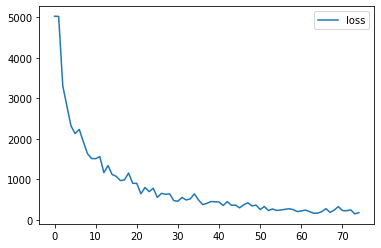

In [0]:
df.plot()

## Save trained model

In [0]:
modelfile = input("Enter your Model Name: ")
tpnlp.to_disk(Path(local_dir/modelfile))

Enter your Model Name: TimePeriodNER_75_v2


## Predict model on test set

In [0]:
# Load saved model
tpnlp = spacy.load(Path(local_dir/modelfile))

test_results_dict = defaultdict(list)
true_texts = []
true_labels = []
for test_instance in TEST_DATA:
  test_sentence, entities = test_instance        
  test_doc = tpnlp(test_sentence)
  true_texts.append([test_sentence[original_entity[0]:original_entity[1]] for original_entity in entities['entities']])
  true_labels.append([original_entity[2] for original_entity in entities['entities']])
  predicted_texts = []
  predicted_labels = []
  for ent in test_doc.ents:
    predicted_texts.append(ent.text)
    predicted_labels.append(ent.label_)
  test_results_dict['sentence'].append(test_sentence)
  test_results_dict['predicted_text'].append(predicted_texts)
  test_results_dict['predicted_label'].append(predicted_labels)
test_results = pd.DataFrame(test_results_dict)
test_results['true_text'] = true_texts
test_results['true_label'] = true_labels

In [0]:
test_results.head()

,sentence,predicted_text,predicted_label,true_text,true_label
0,"For adults, the incubation periods for the maj...","[incubation periods for the majority, 1-9 days...","[TPcontext, TPdata]",[incubation periods for the majority (66.5%) o...,"[TPcontext, TPdata]"
1,Shandong Province showed an longer period (mor...,[characterized by sustained local transmission...,"[TPcontext, TPcontext, TPdata]","[average serial interval, 5.9 days]","[TPcontext, TPdata]"
2,Comparing those under and over-60 years of age...,[],[],"[60 years, age]","[TPdata, TPcontext]"
3,Cases detected through symptom-based surveilla...,[Cases detected through symptom-based surveill...,"[TPcontext, TPdata, TPdata, TPcontext]",[Cases detected through symptom-based surveill...,"[TPcontext, TPdata, TPdata, TPcontext]"
4,The median duration from Macau arrival to admi...,[median duration from Macau arrival to admissi...,"[TPcontext, TPdata]",[median duration from Macau arrival to admissi...,"[TPcontext, TPdata]"


In [0]:
test_results[['sentence','true_text','true_label','predicted_text','predicted_label']].to_csv(local_dir/'time_period_results_v2.csv', index=False)

# Evaluate model

Based on methods outlined [here](https://towardsdatascience.com/entity-level-evaluation-for-ner-task-c21fb3a8edf).

In [0]:
def calc_cf(x):
  '''Returns a data frame of predicted and actual texts along with the classification label'''
  results_list = []
  sentence = x['sentence']
  true_text = x['true_text']
  predicted_text = x['predicted_text']
  true_label = x['true_label']
  predicted_label = x['predicted_label']
  if len(true_label) == len(predicted_label):
    texts = list(zip(true_text,predicted_text))
    labels = list(zip(true_label, predicted_label))
    for i in range(len(texts)):
      (true_text, predict_text) = texts[i]
      (true_label, predict_label) = labels[i]
      if ((true_text in predict_text) and (true_label == predict_label)) or ((predict_text in true_text) and (true_label == predict_label)):
        label = 'tp'
      elif ((true_label == predict_label) and (true_text != predict_text)) or (true_label != predict_label):
        label = 'fn & fp'
      else:
        continue
      results_list.append({'sentence':sentence,'true_text':true_text,'predicted_text':predict_text,'true_label':true_label,'predicted_label':predict_label,'cf_label':label})  
  else:
    results_list = compare_two_list(true_label, predicted_label, true_text, predicted_text, sentence)
  results_df = pd.DataFrame(results_list,columns=['sentence','true_text','predicted_text','true_label','predicted_label','cf_label'])
  return results_df

In [0]:
def compare_two_list(true_label, predicted_label, true_text, predicted_text, sentence):
  '''Compare actual and predicted text if they have different lengths'''
  results_list = []
  dic = {}
  # Get true positive matches
  for i in range(len(true_text)):
    for j in range(len(predicted_text)):
      if ((predicted_text[j] in true_text[i]) and (true_label[i] == predicted_label[j])) or ((true_text[i] in predicted_text[j]) and (true_label[i] == predicted_label[j])):
        dic[true_text[i]] = predicted_text[j]
        label = 'tp'
        predict_text = predicted_text[j]
        actual_text = true_text[i]
        actual_label = true_label[i]
        predict_label = predicted_label[j]
        results_list.append({'sentence':sentence,'true_text':actual_text,'predicted_text':predict_text,'true_label':actual_label,'predicted_label':predict_label,'cf_label':label})
        break  
  # Get false negatives
  for t in range(len(true_text)):
    if true_text[t] not in dic.keys():
      label1 = 'fn'
      actual_text1 = true_text[t]
      actual_label1 = true_label[t]
      predict_text1 = None
      predict_label1 = None
      results_list.append({'sentence':sentence,'true_text':actual_text1,'predicted_text':predict_text1,'true_label':actual_label1,'predicted_label':predict_label1,'cf_label':label1})
  # Get false positives
  for p in range(len(predicted_text)):
    if predicted_text[p] not in dic.values():
      label2 = 'fp'
      actual_text2 = None
      actual_label2 = None
      predict_text2 = predicted_text[p]
      predict_label2 = predicted_label[p]
      results_list.append({'sentence':sentence,'true_text':actual_text2,'predicted_text':predict_text2,'true_label':actual_label2,'predicted_label':predict_label2,'cf_label':label2})
  return results_list

In [0]:
# Running code for entire data frame
test_results_labels = pd.DataFrame()
for i in range(len(test_results)):
  res = calc_cf(test_results.loc[i])
  test_results_labels = pd.concat([test_results_labels,res], ignore_index=True)

In [0]:
def calc_stats(x, label):
  '''Calculate statistics for confusion matrix'''
  fn = 0
  fp = 0
  tp = 0
  for i in range(len(x)):
    if x.loc[i][label] == 'fn & fp':
      fn += 1
      fp += 1
    elif x.loc[i][label] == 'fn':
      fn += 1
    elif x.loc[i][label] == 'fp':
      fp += 1
    else:
      tp += 1
  return (fn, fp, tp)

In [0]:
(fn, fp, tp) = calc_stats(test_results_labels,'cf_label')
print('Number of false negatives',fn)
print('Number of false postitives', fp)
print('Number of true positives', tp)
print('Total Number of records', fn+fp+tp)

Number of false negatives 42
Number of false postitives 42
Number of true positives 208
Total Number of records 292


In [0]:
def cf(tp, fp, fn):
  '''Calculate precision, recall, and f1-score'''
  recall = tp/(tp+fn)
  precision = tp/(tp+fp)
  f1 = (2*recall*precision)/(recall+precision)
  return (recall, precision, f1)

In [0]:
recall, precision, f1 = cf(tp, fp, fn)

In [0]:
print('Precision',round(precision,2))
print('Recall',round(recall,2))
print('F1 score',round(f1,2))

Precision 0.83
Recall 0.83
F1 score 0.83


In [0]:
test_results.head(10)

,sentence,predicted_text,predicted_label,true_text,true_label
0,"For adults, the incubation periods for the maj...","[incubation periods for the majority, 1-9 days...","[TPcontext, TPdata]",[incubation periods for the majority (66.5%) o...,"[TPcontext, TPdata]"
1,Shandong Province showed an longer period (mor...,[characterized by sustained local transmission...,"[TPcontext, TPcontext, TPdata]","[average serial interval, 5.9 days]","[TPcontext, TPdata]"
2,Comparing those under and over-60 years of age...,[],[],"[60 years, age]","[TPdata, TPcontext]"
3,Cases detected through symptom-based surveilla...,[Cases detected through symptom-based surveill...,"[TPcontext, TPdata, TPdata, TPcontext]",[Cases detected through symptom-based surveill...,"[TPcontext, TPdata, TPdata, TPcontext]"
4,The median duration from Macau arrival to admi...,[median duration from Macau arrival to admissi...,"[TPcontext, TPdata]",[median duration from Macau arrival to admissi...,"[TPcontext, TPdata]"
5,"Second, due to the massive number of patients ...","[lack of medical resources, the interval from ...","[TPcontext, TPdata]",[interval from the illness onset to hospital a...,"[TPcontext, TPdata]"
6,The mean incubation period is 6.4 days (95% 17...,"[mean incubation period, 6.4 days (95% 175 CI ...","[TPcontext, TPdata, TPcontext, TPcontext, TPdata]","[mean incubation period, 6.4 days (95% 175 CI ...","[TPcontext, TPdata, TPcontext, TPdata]"
7,The median duration to negative reverse-transc...,"[median duration to negative, 11 days (95 CIs:...","[TPcontext, TPdata]",[median duration to negative reverse-transcrip...,"[TPcontext, TPdata]"
8,6 Older individuals (aged >60 years) and peopl...,[>60 years)],[TPdata],"[aged , >60 years]","[TPcontext, TPdata]"
9,"The median age was 51 years old (IQR, 36-64 ye...","[median age, 51 years old (IQR, 36-64 years)]","[TPcontext, TPdata]","[median age , 51 years old (IQR, 36-64 years)]","[TPcontext, TPdata]"


In [0]:
test_results_labels.head(20)

,sentence,true_text,predicted_text,true_label,predicted_label,cf_label
0,"For adults, the incubation periods for the maj...",incubation periods for the majority (66.5%) of...,incubation periods for the majority,TPcontext,TPcontext,tp
1,"For adults, the incubation periods for the maj...",1-9 days,1-9 days: most of them,TPdata,TPdata,tp
2,Shandong Province showed an longer period (mor...,average serial interval,average serial interval,TPcontext,TPcontext,tp
3,Shandong Province showed an longer period (mor...,5.9 days,5.9 days,TPdata,TPdata,tp
4,Shandong Province showed an longer period (mor...,None,characterized by sustained local transmission,None,TPcontext,fp
5,Comparing those under and over-60 years of age...,60 years,None,TPdata,None,fn
6,Comparing those under and over-60 years of age...,age,None,TPcontext,None,fn
7,Cases detected through symptom-based surveilla...,Cases detected through symptom-based surveillance,Cases detected through symptom-based surveilla...,TPcontext,TPcontext,tp
8,Cases detected through symptom-based surveilla...,"average 5.5 days (95% CI 5.0, 5.9) after sympt...","on average 5.5 days (95% CI 5.0, 5.9) after sy...",TPdata,TPdata,tp
9,Cases detected through symptom-based surveilla...,"3.2 days (95% CI 2.6,3.7)","3.2 days (95% CI 2.6,3.7)",TPdata,TPdata,tp


In [0]:
test_results_labels.to_csv(local_dir/'evaluation_labels_v2.csv',index=False)